In [ ]:
!nvidia-smi

In [6]:
import matplotlib as mpl
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
from matplotlib import pyplot as plt
from corner import corner

from gigalens.tf.inference import ModellingSequence
from gigalens.tf.model import ForwardProbModel, BackwardProbModel
from gigalens.model import PhysicalModel
from gigalens.tf.simulator import LensSimulator
from gigalens.simulator import SimulatorConfig
from gigalens.tf.profiles.light import sersic
from gigalens.tf.profiles.mass import epl, shear

sns.set_style("whitegrid")
tfd = tfp.distributions

In [7]:
lens_prior = tfd.JointDistributionSequential(
    [
        tfd.JointDistributionNamed(
            dict(
                theta_E=tfd.LogNormal(tf.math.log(1.25), 0.25),
                gamma=tfd.TruncatedNormal(2, 0.25, 1, 3),
                e1=tfd.Normal(0, 0.1),
                e2=tfd.Normal(0, 0.1),
                center_x=tfd.Normal(0, 0.05),
                center_y=tfd.Normal(0, 0.05),
            )
        ),
        tfd.JointDistributionNamed(
            dict(gamma1=tfd.Normal(0, 0.05), gamma2=tfd.Normal(0, 0.05))
        ),
    ]
)
lens_light_prior = tfd.JointDistributionSequential(
    [
        tfd.JointDistributionNamed(
            dict(
                R_sersic=tfd.LogNormal(tf.math.log(1.0), 0.15),
                n_sersic=tfd.Uniform(2, 6),
                e1=tfd.TruncatedNormal(0, 0.1, -0.3, 0.3),
                e2=tfd.TruncatedNormal(0, 0.1, -0.3, 0.3),
                center_x=tfd.Normal(0, 0.05),
                center_y=tfd.Normal(0, 0.05),
                Ie=tfd.LogNormal(tf.math.log(500.0), 0.3),
            )
        )
    ]
)

source_light_prior = tfd.JointDistributionSequential(
    [
        tfd.JointDistributionNamed(
            dict(
                R_sersic=tfd.LogNormal(tf.math.log(0.25), 0.15),
                n_sersic=tfd.Uniform(0.5, 4),
                e1=tfd.TruncatedNormal(0, 0.15, -0.5, 0.5),
                e2=tfd.TruncatedNormal(0, 0.15, -0.5, 0.5),
                center_x=tfd.Normal(0, 0.25),
                center_y=tfd.Normal(0, 0.25),
                Ie=tfd.LogNormal(tf.math.log(150.0), 0.5),
            )
        )
    ]
)

prior = tfd.JointDistributionSequential(
    [lens_prior, lens_light_prior, source_light_prior]
)

2024-03-12 02:54:59.395438: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22453 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6
2024-03-12 02:54:59.395743: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22453 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:08:00.0, compute capability: 8.6
2024-03-12 02:54:59.566397: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [8]:
prior.sample(2)

[[{'theta_E': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1.1301485, 1.0428953], dtype=float32)>,
   'gamma': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1.6588398, 1.9984273], dtype=float32)>,
   'e2': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-0.0619163 ,  0.00233309], dtype=float32)>,
   'e1': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-0.01283669, -0.00356896], dtype=float32)>,
   'center_y': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-0.04219625,  0.12536295], dtype=float32)>,
   'center_x': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.04644866, 0.02562884], dtype=float32)>},
  {'gamma2': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 0.07047782, -0.02301031], dtype=float32)>,
   'gamma1': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-0.02690522, -0.06794389], dtype=float32)>}],
 [{'n_sersic': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([5.467633, 5.799644], dtype=float32)>,
   'e2': <tf.Tensor: shape=(2,), d

Load the data. The ground truth parameters are in `truth`. Various hyperparameters, including the noise scale and exposure time are fixed.

The PSF is generated from `TinyTim` for HST F140W band, and has been supersampled to the pixel scale of 0.065.

In [9]:
truth = [[
    {'theta_E': 1.1, 'gamma': 2.0, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.0},
    {'gamma1': -0.01, 'gamma2': 0.03}
], [
    {'R_sersic': 0.8, 'n_sersic': 2.5, 'e1': 0.09534746574143645, 'e2': 0.14849487967198177, 'center_x': 0.1, 'center_y': 0.0, 'Ie': 499.3695906504067}
], [
    {'R_sersic': 0.25, 'n_sersic': 1.5, 'e1': 0., 'e2': 0., 'center_x': 0.09566681002252231, 'center_y': -0.0639623054267272, 'Ie': 149.58828877085668}
]]

In [10]:
import gigalens
root = gigalens.__path__[0]
kernel = np.load(f'{root}/assets/psf.npy').astype(np.float32)
sim_config = SimulatorConfig(delta_pix=0.065, num_pix=60, supersample=2, kernel=kernel)
phys_model = PhysicalModel([epl.EPL(50), shear.Shear()], [sersic.SersicEllipse(use_lstsq=False)], [sersic.SersicEllipse(use_lstsq=False)])
lens_sim = LensSimulator(phys_model, sim_config, bs=1)
observed_img = np.load(f'{root}/assets/demo.npy')
prob_model = ForwardProbModel(prior, observed_img, background_rms=0.2, exp_time=100)
model_seq = ModellingSequence(phys_model, prob_model, sim_config)

2024-03-12 02:55:09.662779: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x528d8d0


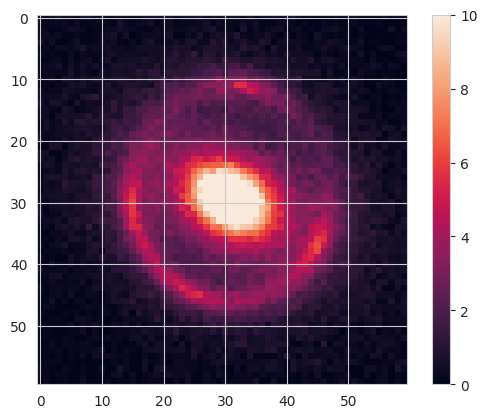

In [11]:
plt.imshow(observed_img, vmin=0, vmax=10)
plt.colorbar()

Sanity check: calculate residuals using ground truth.

Chi-square: 0.98125166


2024-03-12 02:55:12.173585: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2024-03-12 02:55:12.211088: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


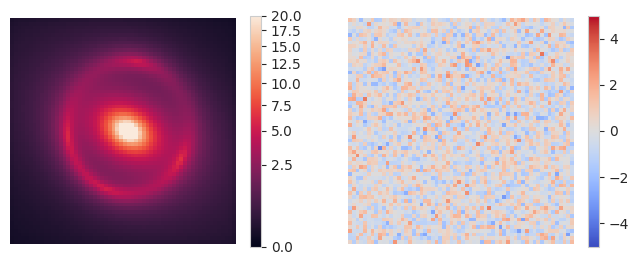

In [12]:
plt.figure(figsize=(8, 3))
plt.subplot(121)
plt.imshow(lens_sim.simulate(truth), norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=20),)
plt.colorbar()
plt.axis('off')
plt.subplot(122)
simulated = lens_sim.simulate(truth)
resid = simulated - observed_img
background_rms, exp_time = 0.2, 100
err_map = np.sqrt(background_rms**2 + simulated/exp_time)
plt.imshow(resid/err_map, cmap='coolwarm', interpolation='none', vmin=-5, vmax=5)
print('Chi-square:', np.mean((resid/err_map)**2))
plt.axis('off')
plt.colorbar()

Begin fitting. We use `supersample=1` for this demonstration to speed things up, but setting `supersample=2` is recommended in practice. This will not significantly slow down the fitting.

In [13]:
fitter = ModellingSequence(phys_model, prob_model, sim_config)

In [14]:
n_map = 500
schedule_fn = tf.keras.optimizers.schedules.PolynomialDecay(1e-2, 300, 1e-2/5)
optimizer = tf.keras.optimizers.Adam(schedule_fn)
MAP = fitter.MAP(optimizer=optimizer, n_samples=n_map, num_steps=300, seed=0)

  0%|          | 0/300 [00:00<?, ?it/s]

2024-03-12 02:55:33.243178: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f3548008c50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-12 02:55:33.243196: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-03-12 02:55:33.243199: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-03-12 02:55:33.246158: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1710233733.291223 1556381 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [15]:
lens_sim_n_MAP = LensSimulator(phys_model, sim_config, bs=n_map)
lps = prob_model.log_prob(lens_sim_n_MAP, MAP)[0]
best = MAP[tf.argmax(lps).numpy()]

In [16]:
schedule_fn = tf.keras.optimizers.schedules.PolynomialDecay(0.0, 500, 4e-3, 2)
optimizer = tf.keras.optimizers.Adam(schedule_fn)
q_z, losses = fitter.SVI(optimizer=optimizer, start=best, n_vi=500, num_steps=1000)

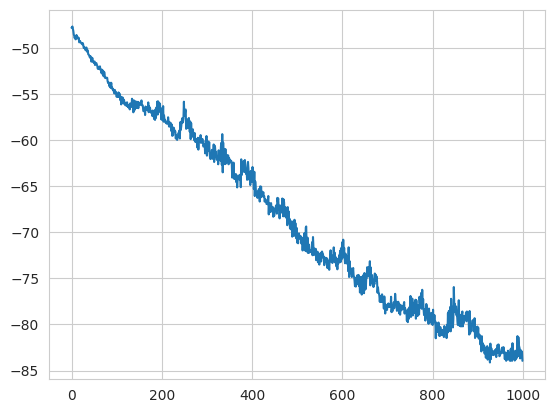

In [17]:
plt.plot(losses)

Although the loss is still declining, the VI results are sufficient for our sampling.

In [18]:
samples, sample_stats = fitter.HMC(q_z, n_hmc=50, init_eps=0.3, init_l=3, max_leapfrog_steps=300,
                                   num_burnin_steps=250, num_results=750)

/home/parlange/anaconda3/envs/gigalens/lib/python3.10/site-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


  0%|          | 0/999 [00:00<?, ?it/s]

In [19]:
Rhat = tfp.mcmc.potential_scale_reduction(samples).numpy()
ESS = tfp.mcmc.effective_sample_size(samples, cross_chain_dims=1).numpy()
print(Rhat, ESS)

[1.0017809 1.001422  1.0030878 1.0046979 1.0151745 1.0099416 1.0170658
 1.0102834 1.0015962 1.0025247 1.0017214 1.0018386 1.0016593 1.000783
 1.0010033 1.0037054 1.0053859 1.0004773 1.0123549 1.0017656 1.0006434
 1.0033811] [24933.812  18503.545  11851.409   8728.915   3549.1768  5336.9365
  3182.755   5249.764  21234.893  16525.229  22263.945  19394.777
 23925.277  24332.062  27343.96   11241.862   8711.709  26233.328
  4284.137  15054.455  25830.982  12181.062 ]


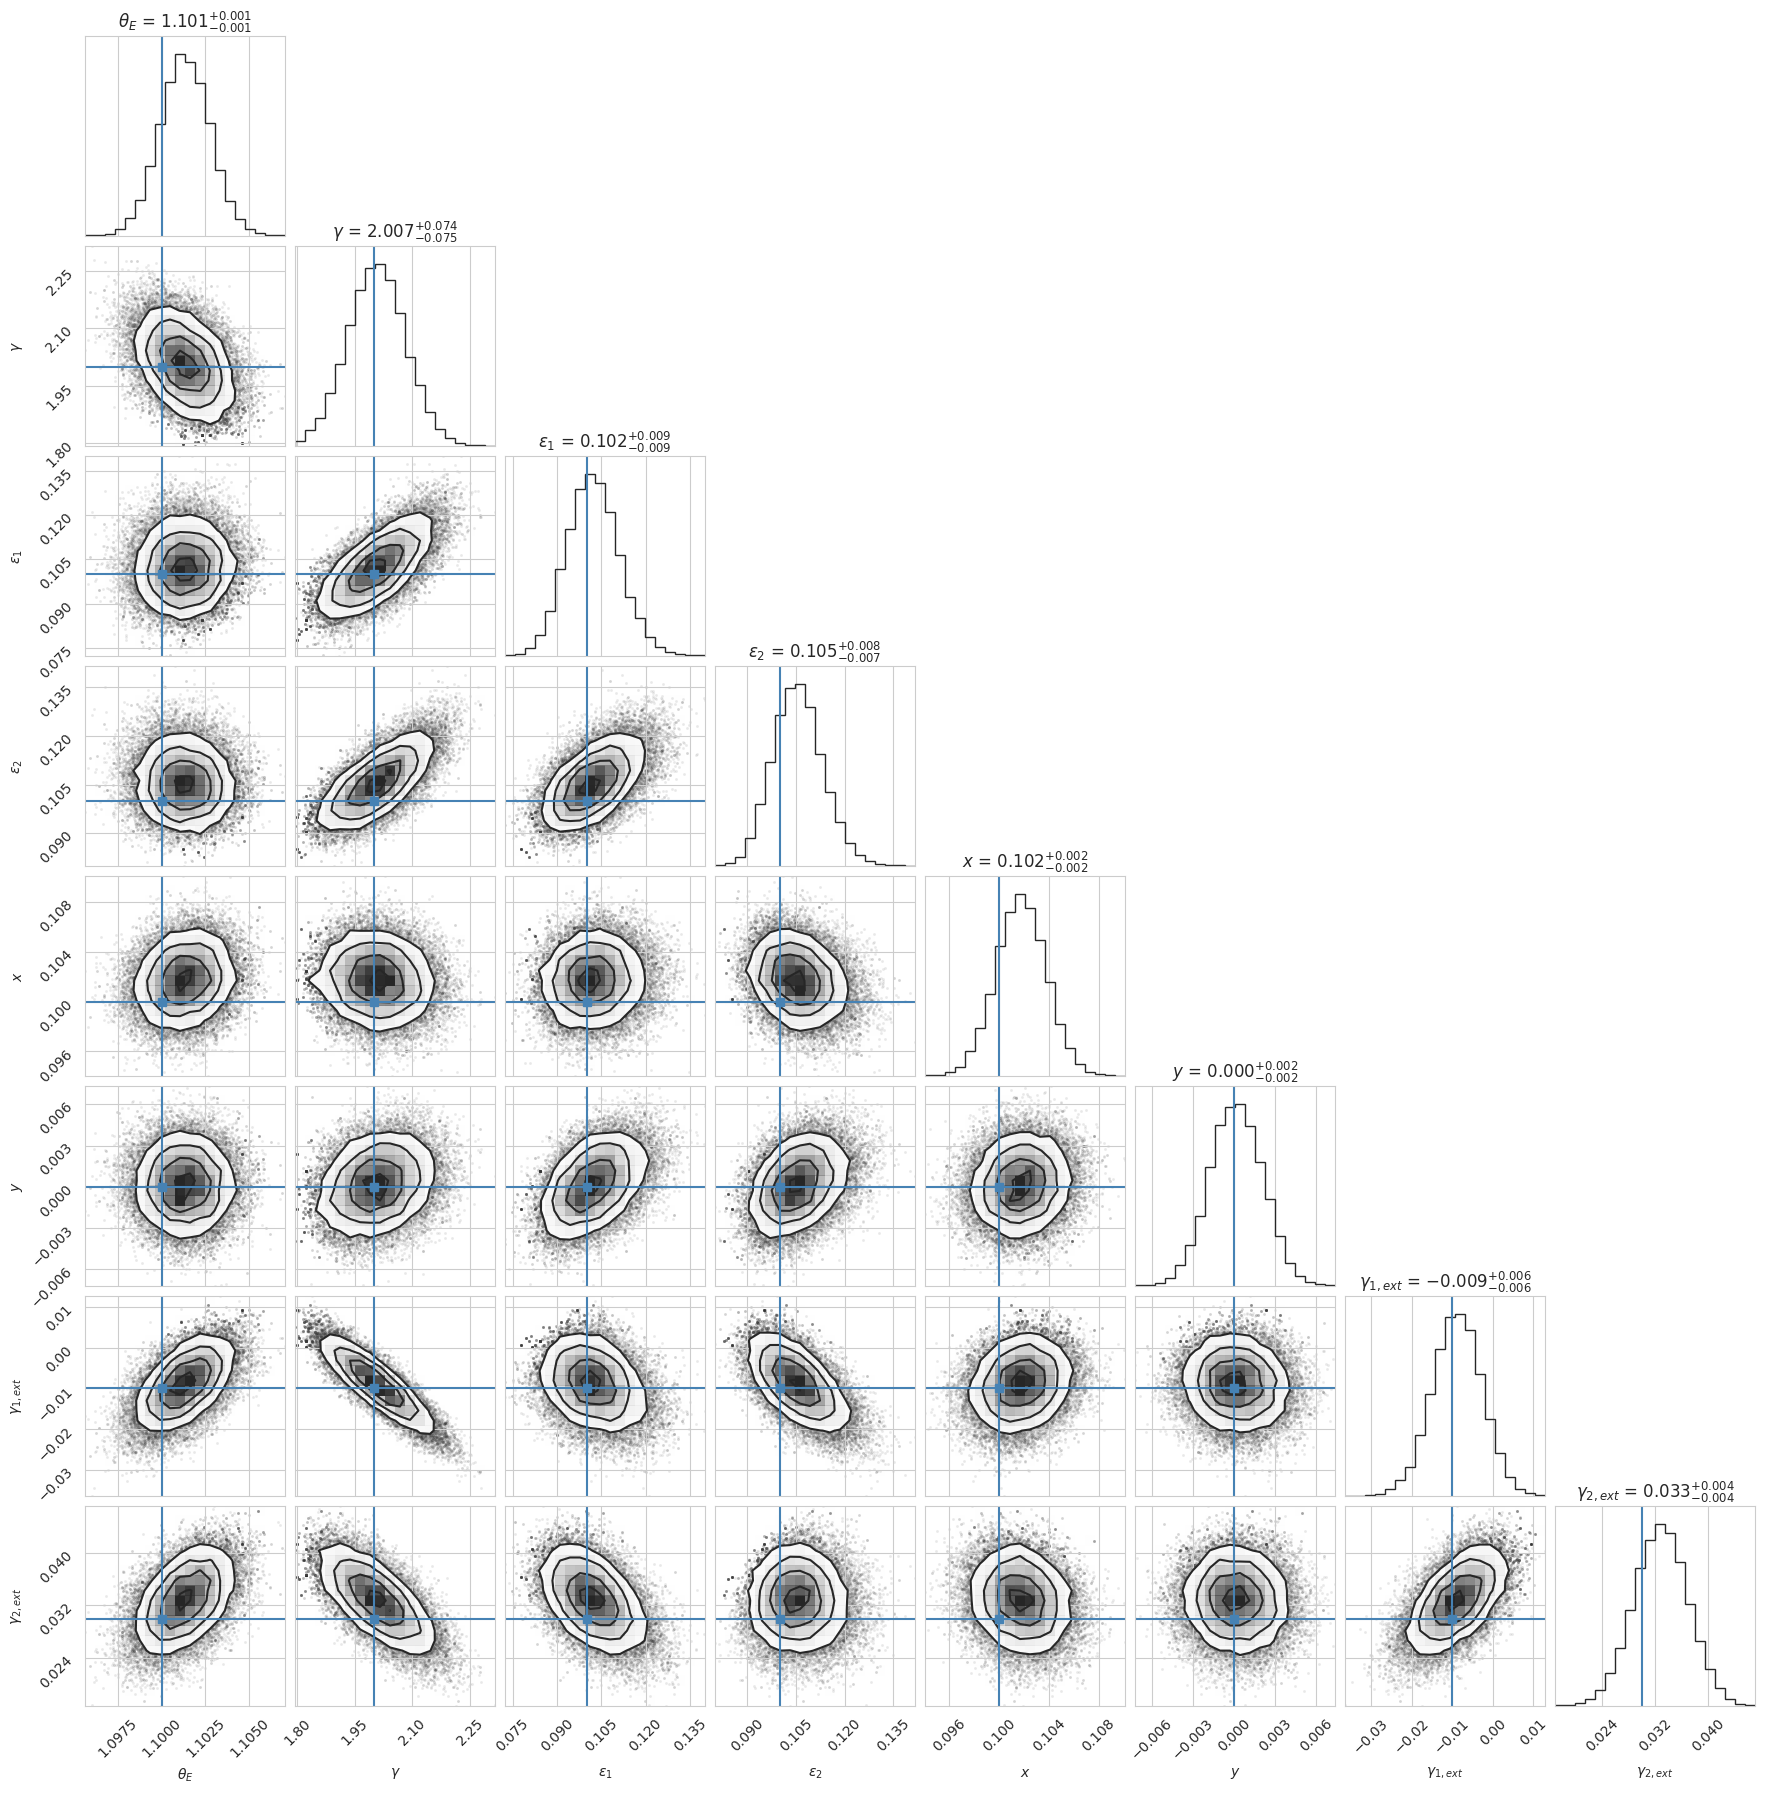

In [20]:
get_samples = lambda x: tf.convert_to_tensor([
    x[0][0]['theta_E'],
    x[0][0]['gamma'],
    x[0][0]['e1'],
    x[0][0]['e2'],
    x[0][0]['center_x'],
    x[0][0]['center_y'],
    x[0][1]['gamma1'],
    x[0][1]['gamma2'],
])
physical_samples = get_samples(prob_model.bij.forward(samples)).numpy()
markers = get_samples(truth)
corner(physical_samples.reshape((8,-1)).T, truths=markers, 
       show_titles=True, title_fmt='.3f',
       labels=[r'$\theta_E$', r'$\gamma$', r'$\epsilon_1$', r'$\epsilon_2$', r'$x$', r'$y$', r'$\gamma_{1,ext}$', r'$\gamma_{2,ext}$']);